In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pprint import pprint
import time

import inputools.Trajectory as it
from tools.evolutions import load_best_individual
import src.models as mm
from src.models import logger
import src.visualizations as mv
import src.agents as agents

from tools.utils import clf, tqdm_enumerate, save_image

%load_ext autoreload
%autoreload 2

plt.style.use('classic')
logger()

2024-02-16 20:39:32 | 


This notebook is about the study of active navigation by exploiting a formed place cell layer.

## hard-coded PC layer 
---

#### Trajectory

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:00<00:00, 127606.20it/s]


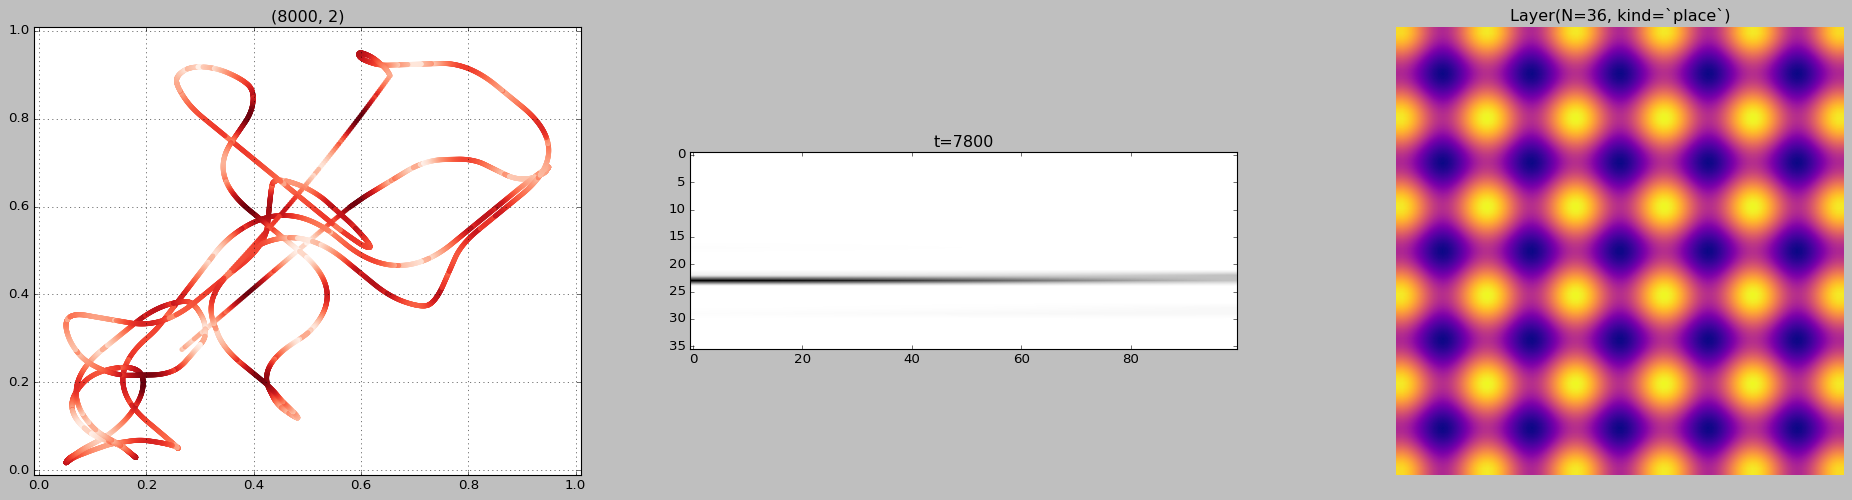

In [63]:
# input
duration = 8
speed = 1
dt = 1e-4
Nj = 6**2
sigma = 0.01

trajectory = it.make_trajectory(duration=duration, dt=dt, speed=[speed, speed], 
                                  prob_turn=0.005, k_average=200, dim=2)

#layer = it.HDLayer(N=5**2, sigma=0.01)
layer = it.PlaceLayer(N=Nj, sigma=sigma)

A = layer.parse_trajectory(trajectory=trajectory)

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 7))
z = np.zeros(len(A))
for i in range(len(A[0])):
    z += np.where(A[:, i] > 0.1, A[:, i], 0)

ax1.scatter(trajectory[:, 0], trajectory[:, 1], c=z, s=20, cmap='Reds',
           edgecolors='black', linewidths=0)
ax1.set_ylim((-0.01, 1.01))
ax1.set_xlim((-0.01, 1.01))
ax1.grid()
ax1.set_title(trajectory.shape)

for t in range(0, len(A)-100, 100):
    ax2.imshow(A[t:t+100, :].T, cmap='Greys')
    ax2.set_title(f"{t=}")
    
layer.plot(size=100, kind='imshow', sigmoid_beta=0.01, sigmoid_alpha=0., ax=ax3)

In [64]:
trajectory[-1]

array([0.340905, 0.432995])

In [72]:
agent = agents.AgentPC(Npc=5**2, Nh=10, start_position=trajectory[0], step_size=0.0001, activation='sigmoid')
agent.current_position

array([[0.26617],
       [0.27475]])

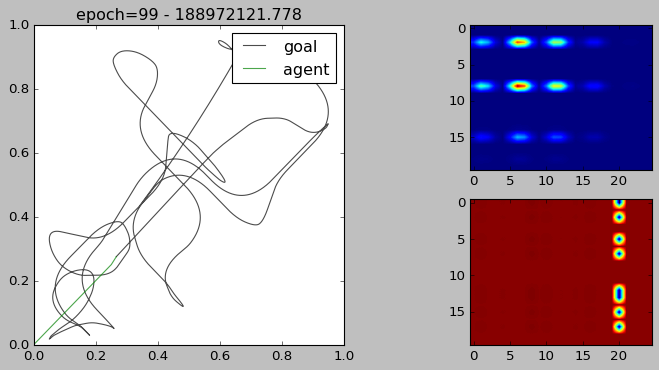

In [109]:
""" initialization """

agent = agents.AgentPC(Npc=5**2, Nh=20, start_position=trajectory[0].copy(), step_size=0.01, lr=-0.05, activation='sigmoid')
logger(agent)

epochs = 100
epoch_log = int(max((epochs*0.01, 1)))
for epoch in range(epochs):

    agent.set_position(position=trajectory[0].copy().reshape(-1, 1))
    positions = np.zeros_like(trajectory.copy())
    positions[0] = trajectory[0].copy()
    loss = 0.
    for t in range(1, len(trajectory)-1):
        positions[t] = agent(goal_position=trajectory[-1].copy().reshape(-1, 1))
        loss += agent.update(target_position=trajectory[t].copy().reshape(-1, 1))
    #print(positions, end=' ')

    if epoch % epoch_log == 0:

        clf()
        plt.figure(figsize=(11, 5))
        plt.subplot(121)
        plt.plot(trajectory[:, 0], trajectory[:, 1], '-k', alpha=0.7, label="goal")
        plt.plot(positions[:, 0], positions[:, 1], '-g', alpha=0.7, label="agent")
        plt.legend()
        plt.title(f"{epoch=} - {loss:.3f}")

        plt.subplot(222)
        plt.imshow(agent.grad_h)

        plt.subplot(224)
        plt.imshow(agent.grad_out.T)
        plt.pause(0.0001)

In [11]:
positions

array([[122.12953956,  58.1979013 ],
       [122.12963956,  58.1979013 ],
       [122.12973956,  58.1979013 ],
       ...,
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ]])